In [32]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.dummy import DummyRegressor
from sklearn.feature_selection import SequentialFeatureSelector, SelectFromModel
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
import pickle
from scipy.ndimage import shift
import lightgbm as lgb
from sklearn.linear_model import ElasticNetCV

In [5]:
train = pd.read_csv("../../kaggle_data/train.csv")
test = pd.read_csv("../../kaggle_data/test.csv")

In [6]:
train = train.loc[np.all(train.notna(), axis=1), :]
parentspecies_mapping = {
    'toluene': 1,
    'apin': 2,
    'decane': 3,
    'apin_toluene': 4,
    'apin_decane': 5,
    'apin_decane_toluene': 6,
    'decane_toluene': 7
}
train['parentspecies'] = train['parentspecies'].map(parentspecies_mapping)
test['parentspecies'] = test['parentspecies'].map(parentspecies_mapping)

In [7]:
train_x = train.loc[:, ~train.columns.isin(['log_pSat_Pa', 'ID'])]
train_y = train['log_pSat_Pa']

## Default model scores

In [8]:
dummy = DummyRegressor(strategy='mean')
dummy_scores = cross_val_score(dummy, train_x, train_y, cv=10, scoring='r2')

In [12]:
rf = RandomForestRegressor()
rf_scores = cross_val_score(rf, train_x, train_y, cv=10, scoring='r2')

In [13]:
svm_pipe = make_pipeline(StandardScaler(), SVR())
svm_scores = cross_val_score(svm_pipe, train_x, train_y, cv=10, scoring='r2')

In [ ]:
gb = HistGradientBoostingRegressor(categorical_features=['parentspecies'])
gb_scores = cross_val_score(gb, train_x, train_y, cv=10, scoring='r2')

0.7443802749508285


In [29]:
models = ['dummy', 'RF', 'SVR', 'GB', 'SVR_linear', 'SVR_Poly_4']
scores = [np.mean(dummy_scores), np.mean(rf_scores), np.mean(svm_scores), np.mean(gb_scores), np.mean(svm_linear_scores), np.mean(svm_poly_scores_dg4)]
score_df = pd.DataFrame({'Models': models, 'Scores': scores})
print(score_df)

       Models    Scores
0       dummy -0.000264
1          RF  0.717607
2         SVR  0.746615
3          GB  0.743940
4  SVR_linear  0.704179
5  SVR_Poly_4  0.634562


In [ ]:
train_pol = train_x.copy()

for column in train_pol.columns:
    if column != 'log_pSat_Pa':
        try:
            train_pol[column] = train_pol[column] ** 2
        except (ValueError, AttributeError):
            pass


## Feature selection

### Random Forest

In [9]:
def select_only_important_features(
    feature_importances: pd.Series,
    rfr_model,
    X_train: pd.DataFrame,
    y_train: pd.DataFrame | np.ndarray,
):
    best_features = []
    r2_scores = []
    best_r2_score = 0
    
    for i in range(0, feature_importances.shape[0]):
        features = feature_importances.index[0:i+1].to_list()
        model = rfr_model.fit(X_train.loc[:, features], y_train)
        scores = cross_val_score(model, X_train.loc[:, features], y_train, cv=3, scoring='r2')
        mean_score = np.mean(scores)
        if mean_score > best_r2_score:
            best_features = features
            best_r2_score = mean_score
        r2_scores.append(mean_score)

    return best_features, r2_scores

In [ ]:
rf = RandomForestRegressor()
rf_fit = rf.fit(train_x, train_y)
rf_feature_importances = pd.Series(rf_fit.feature_importances_, index=train_x.columns)
rf_feature_importances = rf_feature_importances.sort_values(ascending=False)
print(rf_feature_importances)

In [12]:
print(rf_feature_importances)

NumHBondDonors                  0.471540
NumOfC                          0.119223
NumOfConf                       0.112079
NumOfConfUsed                   0.055099
NumOfAtoms                      0.053596
MW                              0.025135
hydroxyl (alkyl)                0.020012
carbonylperoxynitrate           0.019487
ketone                          0.017271
carboxylic acid                 0.016109
NumOfO                          0.013918
aldehyde                        0.012627
peroxide                        0.008663
hydroperoxide                   0.008630
carbonylperoxyacid              0.007964
C=C (non-aromatic)              0.007158
ester                           0.007107
parentspecies                   0.005416
nitrate                         0.005218
ether (alicyclic)               0.005111
nitro                           0.004416
NumOfN                          0.002623
nitroester                      0.000830
C=C-C=O in non-aromatic ring    0.000728
aromatic hydroxy

In [48]:
try:
    with open('../pickles/rf_feature_selection_results.pickle', 'rb') as handle:
        rf_feature_selection_results = pickle.load(handle)
        rf_r2_scores = rf_feature_selection_results['r2_results']
except:
    rf_best_features, rf_r2_scores = select_only_important_features(rf_feature_importances, RandomForestRegressor(), train_x, train_y)

rf_feature_selection_df = pd.DataFrame({
    'Num of features': np.arange(1,26),
    'R2 score': rf_r2_scores,
    'R2 gained': rf_r2_scores - shift(rf_r2_scores, 1),
    'Feature added': rf_feature_importances.index
    })
rf_feature_selection_df = rf_feature_selection_df.set_index('Num of features')
print(rf_feature_selection_df)

                 R2 score  R2 gained                 Feature added
Num of features                                                   
1                0.475098   0.475098                NumHBondDonors
2                0.628552   0.153454                        NumOfC
3                0.543776  -0.084776                     NumOfConf
4                0.560953   0.017177                 NumOfConfUsed
5                0.608981   0.048028                    NumOfAtoms
6                0.631989   0.023008                            MW
7                0.662263   0.030274              hydroxyl (alkyl)
8                0.672247   0.009984         carbonylperoxynitrate
9                0.685577   0.013329                        ketone
10               0.693419   0.007843               carboxylic acid
11               0.693699   0.000279                        NumOfO
12               0.695317   0.001618                      aldehyde
13               0.701542   0.006225                      pero

Text(0, 0.5, 'R2')

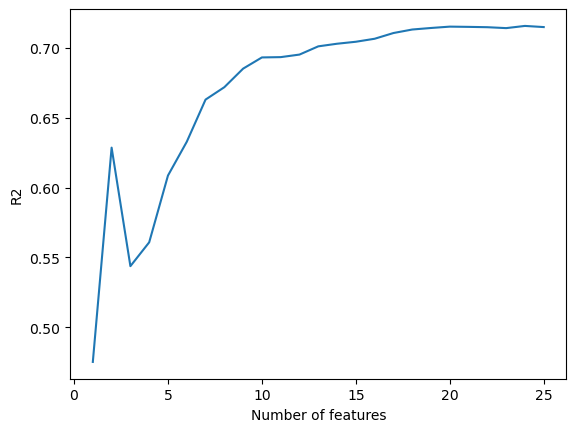

In [ ]:
plt.plot(np.arange(1,26), rf_r2_scores)
plt.xlabel('Number of features')
plt.ylabel('R2')
plt.title('R2 of RF with n most important features')
plt.show()

### Support Vector Regression

In [ ]:
svm_pipe = make_pipeline(StandardScaler(), SVR())
svm_pipe.fit(train_x, train_y)

try:
    with open('../pickles/svm_feature_importances.pickle', 'rb') as handle:
        svm_feature_importances = pickle.load(handle)
except:
    svm_feature_importances = permutation_importance(svm_pipe, train_x, train_y, n_repeats=10, random_state=0)

svm_feature_importance_means = svm_feature_importances.importances_mean
svm_feature_importance_means = pd.Series(svm_feature_importance_means, index=train_x.columns)
svm_feature_importance_means = svm_feature_importance_means.sort_values(ascending=False)
print(svm_feature_importance_means)

NumOfC                          0.342834
NumHBondDonors                  0.246036
NumOfConf                       0.121222
carboxylic acid                 0.099756
NumOfAtoms                      0.060547
hydroperoxide                   0.055878
carbonylperoxyacid              0.044974
peroxide                        0.044873
hydroxyl (alkyl)                0.037951
NumOfConfUsed                   0.032414
MW                              0.030140
carbonylperoxynitrate           0.028654
ketone                          0.027432
NumOfO                          0.025452
ether (alicyclic)               0.022740
parentspecies                   0.022603
C=C (non-aromatic)              0.020821
aldehyde                        0.014401
ester                           0.010083
nitrate                         0.009378
NumOfN                          0.009148
nitro                           0.007216
C=C-C=O in non-aromatic ring    0.005325
nitroester                      0.004249
aromatic hydroxy

In [51]:
try:
    with open('../pickles/svm_feature_selection_results.pickle', 'rb') as handle:
        svm_feature_selection_results = pickle.load(handle)
        svm_r2_scores = svm_feature_selection_results['r2_results']
except:
    svm_best_features, svm_r2_scores = select_only_important_features(svm_feature_importance_means, make_pipeline(StandardScaler(), SVR()), train_x, train_y)

svm_feature_selection_df = pd.DataFrame({
    'Num of features': np.arange(1,26),
    'R2 score': svm_r2_scores,
    'R2 gained': svm_r2_scores - shift(svm_r2_scores, 1),
    'Feature added': svm_feature_importance_means.index
    })
svm_feature_selection_df = svm_feature_selection_df.set_index('Num of features')
print(svm_feature_selection_df)

                 R2 score  R2 gained                 Feature added
Num of features                                                   
1                0.114046   0.114046                        NumOfC
2                0.627052   0.513006                NumHBondDonors
3                0.647806   0.020755                     NumOfConf
4                0.667918   0.020111               carboxylic acid
5                0.673390   0.005472                    NumOfAtoms
6                0.676669   0.003279                 hydroperoxide
7                0.686032   0.009363            carbonylperoxyacid
8                0.693831   0.007799                      peroxide
9                0.693304  -0.000527              hydroxyl (alkyl)
10               0.700344   0.007039                 NumOfConfUsed
11               0.713450   0.013107                            MW
12               0.720374   0.006923         carbonylperoxynitrate
13               0.729345   0.008971                        ke

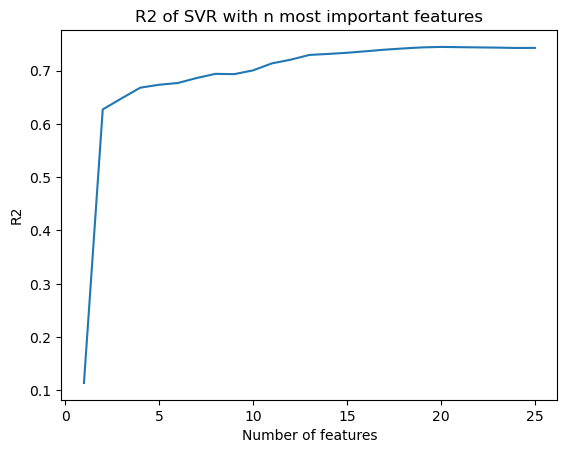

In [55]:
plt.plot(np.arange(1,26), svm_r2_scores)
plt.xlabel('Number of features')
plt.ylabel('R2')
plt.title('R2 of SVR with n most important features')
plt.show()

In [26]:
svm_pipe = make_pipeline(StandardScaler(), SVR(C=2.0, epsilon=0.2))
dropped_features = ['nitrate', 'NumOfN', 'nitro', 'C=C-C=O in non-aromatic ring', 'nitroester', 'aromatic hydroxyl']
svm_scores = cross_val_score(svm_pipe, train_x.loc[:, ~train_x.columns.isin(dropped_features)], train_y, cv=10, scoring='r2')
print(np.mean(svm_scores))

0.750569295610406


In [ ]:
svm_pipe = make_pipeline(StandardScaler(), SVR())

try:
    with open('../pickles/svm_feature_importances.pickle', 'rb') as handle:
        svm_feature_importances = pickle.load(handle)
except:
    svm_feature_importances = permutation_importance(svm_pipe, train_x, train_y, n_repeats=10, random_state=0)

svm_feature_importance_means = svm_feature_importances.importances_mean
svm_feature_importance_means = pd.Series(svm_feature_importance_means, index=train_x.columns)
svm_feature_importance_means = svm_feature_importance_means.sort_values(ascending=False)
print(svm_feature_importance_means)

### Gradient Boosting

In [7]:
gb = HistGradientBoostingRegressor(categorical_features=['parentspecies'])
gb.fit(train_x, train_y)

try:
    with open('../pickles/gb_feature_importances.pickle', 'rb') as handle:
        gb_feature_importances = pickle.load(handle)
except:
    gb_feature_importances = permutation_importance(gb, train_x, train_y, n_repeats=30, random_state=0)

gb_feature_importance_means = gb_feature_importances.importances_mean
gb_feature_importance_means = pd.Series(gb_feature_importance_means, index=train_x.columns)
gb_feature_importance_means = gb_feature_importance_means.sort_values(ascending=False)
print(gb_feature_importance_means)

NumHBondDonors                  0.602000
NumOfC                          0.205928
NumOfConf                       0.145684
carbonylperoxynitrate           0.039451
NumOfConfUsed                   0.036191
peroxide                        0.030956
carboxylic acid                 0.029877
ketone                          0.020907
hydroxyl (alkyl)                0.017233
parentspecies                   0.015249
NumOfO                          0.012145
C=C (non-aromatic)              0.011101
ether (alicyclic)               0.009709
aldehyde                        0.009597
carbonylperoxyacid              0.008306
ester                           0.008162
MW                              0.008031
NumOfAtoms                      0.004993
hydroperoxide                   0.004715
NumOfN                          0.002293
nitro                           0.001595
nitrate                         0.000792
C=C-C=O in non-aromatic ring    0.000735
nitroester                      0.000429
aromatic hydroxy

In [41]:
try:
    with open('../pickles/gb_feature_selection_results.pickle', 'rb') as handle:
        gb_feature_selection_results = pickle.load(handle)
        gb_r2_scores = gb_feature_selection_results['r2_results']
except:
    gb_best_features, gb_r2_scores = select_only_important_features(gb_feature_importance_means, HistGradientBoostingRegressor(), train_x, train_y)

gb_feature_selection_df = pd.DataFrame({
    'Num of features': np.arange(1,26),
    'R2 score': gb_r2_scores,
    'R2 gained': gb_r2_scores - shift(gb_r2_scores, 1),
    'Feature added': gb_feature_importance_means.index
    })
gb_feature_selection_df = gb_feature_selection_df.set_index('Num of features')
print(gb_feature_selection_df)

                 R2 score  R2 gained                 Feature added
Num of features                                                   
1                0.475046   0.475046                NumHBondDonors
2                0.628100   0.153054                        NumOfC
3                0.647914   0.019814                     NumOfConf
4                0.673326   0.025412         carbonylperoxynitrate
5                0.679595   0.006269                 NumOfConfUsed
6                0.685369   0.005774                      peroxide
7                0.699489   0.014120               carboxylic acid
8                0.708239   0.008750                        ketone
9                0.713926   0.005687              hydroxyl (alkyl)
10               0.723280   0.009354                 parentspecies
11               0.728090   0.004811                        NumOfO
12               0.731673   0.003583            C=C (non-aromatic)
13               0.732564   0.000891             ether (alicyc

In [234]:
feat = gb_feature_selection_df.sort_values('R2 gained', ascending=False).iloc[:19, :]['Feature added'].values
gb = HistGradientBoostingRegressor(categorical_features=['parentspecies'],
                              learning_rate=0.01, max_depth=8, max_features=0.1,
                              max_iter=2000, max_leaf_nodes=60,
                              min_samples_leaf=70)
gb_scores = cross_val_score(gb, train_x.loc[:, feat], train_y, cv=10, scoring='r2')
print(np.mean(gb_scores))

0.7502637061921038


In [235]:
# gb = HistGradientBoostingRegressor(categorical_features=['parentspecies'])
gb.fit(train_x, train_y)
test_x = test.loc[:, ~test.columns.isin(['ID'])]
pred = gb.predict(test_x)
df = pd.DataFrame({'ID': test['ID'], 'TARGET': pred})
df = df.set_index('ID')
df.to_csv('gb_submission.csv')

In [30]:
feat = gb_feature_selection_df.sort_values('R2 gained', ascending=False).iloc[:19, :]['Feature added'].values
gb = HistGradientBoostingRegressor(categorical_features=['parentspecies'])
gb_scores = cross_val_score(gb, train_x.loc[:, gb_best_features], train_y, cv=10, scoring='r2')
print(np.mean(gb_scores))

0.7438695983429076


In [37]:
gb_feature_importance = gb_feature_selection_df.sort_values('R2 gained', ascending=False).iloc[:19, :]
gb_feature_importance = gb_feature_importance.set_index('Feature added')
gb_best_features, gb_r2_scores = select_only_important_features(gb_feature_importance, HistGradientBoostingRegressor(), train_x, train_y)

gb_feature_selection_df = pd.DataFrame({
    'Num of features': np.arange(1,20),
    'R2 score': gb_r2_scores,
    'R2 gained': gb_r2_scores - shift(gb_r2_scores, 1),
    'Feature added': gb_feature_importance.index
    })
gb_feature_selection_df = gb_feature_selection_df.set_index('Num of features')
print(gb_feature_selection_df)

                 R2 score  R2 gained          Feature added
Num of features                                            
1                0.475119   0.475119         NumHBondDonors
2                0.628003   0.152884                 NumOfC
3                0.648569   0.020566  carbonylperoxynitrate
4                0.673023   0.024453              NumOfConf
5                0.688399   0.015376        carboxylic acid
6                0.694977   0.006578                 ketone
7                0.706046   0.011069          parentspecies
8                0.710191   0.004145               peroxide
9                0.716780   0.006590       hydroxyl (alkyl)
10               0.724129   0.007348          NumOfConfUsed
11               0.728679   0.004551                 NumOfO
12               0.728939   0.000260      ether (alicyclic)
13               0.732644   0.003704                  ester
14               0.733670   0.001026     carbonylperoxyacid
15               0.737890   0.004220    

In [40]:
feat = gb_feature_selection_df.sort_values('R2 gained', ascending=False).iloc[:15, :]['Feature added'].values
gb = HistGradientBoostingRegressor(categorical_features=['parentspecies'])
gb_scores = cross_val_score(gb, train_x.loc[:, gb_best_features], train_y, cv=10, scoring='r2')
print(np.mean(gb_scores))

0.743680131787265


In [20]:
train_data = lgb.Dataset(train_x, label=train_y, categorical_feature=['parentspecies'])

In [24]:
train_data = lgb.Dataset(train_x, label=train_y, categorical_feature=['parentspecies'])
res = lgb.cv(params={'num_leaves': 7, 'learning_rate': 0.05, 'num_iterations': 1000, 'feature_fraction': 0.4}, train_set=train_data, nfold=10, stratified=False, return_cvbooster=True)

/home/okko/anaconda3/envs/mlops_eng/lib/python3.11/site-packages/lightgbm/engine.py:674: UserWarning: Found 'num_iterations' in params. Will use it instead of 'num_boost_round' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'num_boost_round' argument")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000807 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 670
[LightGBM] [Info] Number of data points in the train set: 23778, number of used features: 24
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.133333 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 670
[LightGBM] [Info] Number of data points in the train set: 23778, number of used features: 24
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.158492 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `for

In [25]:
print(np.min(res['valid l2-mean']))

2.480877727619391


In [ ]:
from optuna.integration import LightGBMTunerCV
train_data = lgb.Dataset(train_x, label=train_y, categorical_feature=['parentspecies'])
params = {
        "objective": "regression",
        "metric": "l2",
        "verbosity": -1,
        "boosting_type": "gbdt",
    }
booster = LightGBMTunerCV(params, train_data, nfold=10, stratified=False)
booster.run()

[I 2024-12-05 14:34:18,042] A new study created in memory with name: no-name-fd160a63-7b5f-44b3-8adb-85667ece44bd
min_child_samples, val_score: 2.452291: 100%|##########| 5/5 [10:28<00:00, 125.71s/it]


In [31]:
print(np.logspace(-2, 10, 13))

[1.e-02 1.e-01 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04 1.e+05 1.e+06 1.e+07
 1.e+08 1.e+09 1.e+10]


In [ ]:
test_x = test.loc[:, ~test.columns.isin(['ID'])]
svm_pipe = make_pipeline(StandardScaler(), SVR(C=2.0, epsilon=0.2))
model = svm_pipe.fit(train_x, train_y)
pred = model.predict(test_x)
df = pd.DataFrame({'ID': test['ID'], 'TARGET': pred})
df = df.set_index('ID')
df.to_csv('gb_submission.csv')
print(np.sum(test_x.isna(),axis=0))

MW                               0
NumOfAtoms                       0
NumOfC                           0
NumOfO                           0
NumOfN                           0
NumHBondDonors                   0
NumOfConf                        0
NumOfConfUsed                    0
parentspecies                   33
C=C (non-aromatic)               0
C=C-C=O in non-aromatic ring     0
hydroxyl (alkyl)                 0
aldehyde                         0
ketone                           0
carboxylic acid                  0
ester                            0
ether (alicyclic)                0
nitrate                          0
nitro                            0
aromatic hydroxyl                0
carbonylperoxynitrate            0
peroxide                         0
hydroperoxide                    0
carbonylperoxyacid               0
nitroester                       0
dtype: int64


In [260]:
from sklearn.metrics import r2_score
boosters = res['cvbooster'].boosters
scores = []
for b in boosters:
    pred = b.predict(train_x)
    scores.append(r2_score(train_y, pred))
print(np.mean(scores))

0.8674429742895315


In [252]:
print(scores)

[0.8089242320034553, 0.8076117619113642, 0.8088657840406828, 0.8073656752006784, 0.8058870799256922, 0.8071305066980403, 0.8082955182892191, 0.8086479251435378, 0.8085977849665151, 0.8084017798263294]


In [261]:
test_x = test.loc[:, ~test.columns.isin(['ID'])]
boosters = res['cvbooster'].boosters
scores = []
for b in boosters:
    pred = b.predict(test_x)
    scores.append(pred)
df = pd.DataFrame({'ID': test['ID'], 'TARGET': np.mean(scores, axis=0)})
df = df.set_index('ID')
df.to_csv('gb_submission.csv')

(5000,)


## Pickle some stuff

In [ ]:
with open('../pickles/svm_feature_importances.pickle', 'wb+') as handle:
    pickle.dump(svm_feature_importances, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [52]:
with open('../pickles/svm_feature_selection_results.pickle', 'wb+') as handle:
    pickle.dump({'r2_results': svm_r2_scores, 'best_features': svm_best_features}, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('../pickles/rf_feature_selection_results.pickle', 'wb+') as handle:
    pickle.dump({'r2_results': rf_r2_scores, 'best_features': rf_best_features}, handle, protocol=pickle.HIGHEST_PROTOCOL)